# Joint latent-observed input covariates

Here we fit the Universal Count Model to a synthetic spike count time series, generated by a simple tuning curve model of a ring bump attractor network representing head direction with a heteroscedastic negative binomial output process.

### Table of contents

1. [**Synthetic data**](#synthetic)
2. [**Fitting the UCM**](#fitting)
4. [**Marginalized SCDs**](#eval)
    - [Goodness-of-fit metrics](#eval_fit)
    - [Computing spike count distributions](#eval_SCD)
    - [Inspecting model parameters](#eval_inspect)

In [1]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import neuroprob as nprb
from neuroprob import utils
from neuroprob.likelihoods.discrete import gen_NB


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [3]:
# seed everything
seed = 123
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

<a id='syn'></a>
## 1. Synthetic data

Here we generate a modulated Poisson population

In [5]:
def random_walk(rng, track_samples):
    x_t = np.empty(track_samples)

    x_t[0] = 0
    rn = rng.normal(size=(track_samples,))
    for k in range(1, track_samples):
        x_t[k] = x_t[k - 1] + 0.5 * rn[k]
    return x_t


def stationary_GP_trajectories(rng, Tl, l, dt, jitter=1e-8):
    """
    generate smooth GP input
    """

    def rbf_kernel(x):
        dx = x[..., None] - x[..., None, :]  # (..., T, T)
        return np.exp(-0.5 * (dx**2))

    T = np.arange(Tl) * dt / l
    K = rbf_kernel(T)
    K.reshape(-1)[:: Tl + 1] += jitter

    L = np.linalg.cholesky(K)
    v = (L @ rng.normal(size=(Tl, 1)))[..., 0]
    return v


def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return (
        A[:, None]
        * np.exp(np.cos(theta[..., None, :] - theta_0[:, None]) / invbeta[:, None])
        + b[:, None]
    )


def modulated_Poisson(rng, neurons, covariates):
    # angular bumps
    angle_0 = np.linspace(0, 2 * np.pi, neurons + 1)[:-1]
    beta = rng.uniform(size=(neurons,)) * 2.6 + 0.4
    rate_0 = rng.uniform(size=(neurons,)) * 4.0 + 3.2
    b = rng.uniform(size=(neurons,)) * 0.1

    # attention
    mu = rng.normal(size=(neurons,))
    sigma = 0.6 * rng.uniform(size=(neurons,)) + 0.6
    A = 1.7 * rng.uniform(size=(neurons,))
    A_0 = np.ones(neurons) * 0.34

    theta = covariates[..., 0]
    activity = HDC_bumps(
        theta,  rate_0, 1 /  beta,  b,  angle_0
    )

    a = covariates[..., 1]
    x = (a[..., None, :] - mu[:, None]) / sigma[:, None]
    modulator = A[:, None] * np.exp(-(x**2)) + A_0[:, None]

    return activity * modulator  # (..., neurons, ts)

In [8]:
### behaviour ###
sample_bin = 0.1  # 100 ms
timesamples = 10000

hd_t = random_walk(rng, timesamples) % (2 * np.pi)

l = 200.0 * sample_bin
a_t = stationary_GP_trajectories(rng, timesamples, l, sample_bin)

covariates = np.stack([hd_t, a_t], axis=1)

In [10]:
# modulated Poisson
neurons = 50

rate = modulated_Poisson(rng, neurons, covariates)
syn_train = rng.poisson(rate * sample_bin).astype(float)

In [2]:
plt.plot(a_t)
plt.show()

NameError: name 'a_t' is not defined

<a id='fitting'></a>
## 2. Building and fitting the UCM


In [16]:
C = 3
out_dims = C*neurons

# kernel
l = 1.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='euclid', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
p = nprb.inputs.priors.AR1(
    torch.tensor(0.), 
    torch.tensor(1.0), 
    1, 
)
v = nprb.inputs.variational.IndNormal(
    torch.rand(timesamples, 1) * 0.1, 
    torch.ones((timesamples, 1)) * 0.1, 
    'euclid', 
    1, 
)

input_data = [
    torch.from_numpy(hd_t), 
    nprb.inputs.prior_variational_pair(1, p, v)
]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, timesamples, batch_info=1000)

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(out_dims, torch.from_numpy(Xu))


# mapping
in_dims = Xu.shape[-1]

gp = nprb.mappings.SVGP(
    in_dims, out_dims, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(out_dims), learn_mean=True
)

# likelihood
basis_mode = 'el'  # exponential-linear
max_count = int(syn_train.max())
likelihood = nprb.likelihoods.discrete.Universal(neurons, C, basis_mode, 'identity', max_count)
likelihood.set_Y(torch.from_numpy(syn_train), batch_info=1000) 

# assemble
gplo = nprb.inference.VI_optimized(input_group, gp, likelihood)
gplo.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_1): prior_variational_pair(
      (prior): AR1(
        (transition): transition_()
      )
      (variational): IndNormal()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Universal(
    (lsoftm): LogSoftmax(dim=-1)
    (mapping_net): Parallel_Linear(in_features=6, out_features=28, channels=50, bias=True)
  )
)

In [17]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.95)
opt_lr_dict = {
    'default': 1e-2, 
}

gplo.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gplo.fit(3000, loss_margin=-1e0, margin_epochs=30, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 378.


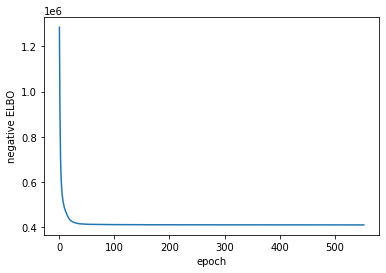

In [18]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='marg'></a>
## 3. Marginalized SCDs


<a id='marg_single'></a>
### 3.1 Single neuron SCDs


<a id='eval'></a>
## 4. Evaluating the UCM

<a id='eval_fit'></a>
### 4.1 Goodness-of-fit metrics

As there is no trial structure, we cannot trivially obtain empirical count distributions from the data to compare with the estimated count distributions from the UCM. Apart from the likelihood score, a more direct measure of goodness-of-fit is given by the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) adapted to count distributions. We compute the predictive spike count distribution given input covariates and then compute the quantiles of the observed spike counts. These are obtained from the training data, and will thus show us how well the model was able to fit in an absolute sense. We can turn these into $Z$-scores (which will be unit normal distributed if the model describes observations well).

In [19]:
# quantiles, Z scores
P_ = []
for b in range(gpr.input_group.batches):
    covariates, _ = gpr.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = utils.model.compute_UCM_P_count(
            gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(neurons):
    spike_binned = gpr.likelihood.all_spikes[trial, n, :].numpy()
    q_ = utils.stats.counts_to_quantiles(P[n, ...], spike_binned, rng)
    q.append(q_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)

We can obtain the Kolmogorov-Smirnov test statistic $T_{KS}$, and the dispersion statistic $T_{DS}$ as well (see paper). These statistics are computed per neuron and reflect single neuron goodness-of-fit measures. The $T_{KS}$ statistic seems to be roughly distributed as the sampling distribution under the null model, i.e. if the model generated the data this would be the distribution of $T_{KS}$ observed for an infinite number of repetitions of random data draws.

In [20]:
T_DS_bn = []
T_KS_bn = []
for qq in q:
    T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_DS_statistics(
        qq, alpha=0.05)
    T_DS_bn.append(T_DS)
    T_KS_bn.append(T_KS)

T_DS_bn = np.array(T_DS_bn)  # (neurons,)
T_KS_bn = np.array(T_KS_bn)


x = np.linspace(0, 0.02, 100)
bins = np.linspace(0, 0.02, 50)
f = utils.stats.KS_sampling_dist(x, len(q[0]))

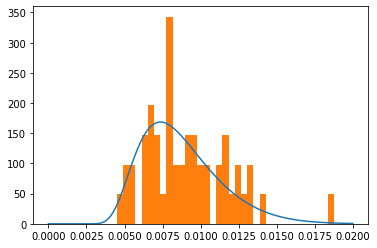

In [21]:
plt.plot(x, f)
plt.hist(T_KS_bn, bins=bins, density=True)
plt.show()

<a id='eval_SCD'></a>
### 4.2 Computing spike count distributions

We can compute the spike count distribution conditioned on input covariates, and in this way we can explore the neural tuning over a slice through input space. We set all other covariates at the mean values of the observed time series in the dataset.

In [22]:
hd_sweep = np.linspace(0, 2*np.pi, 100)
covariates = torch.from_numpy(hd_sweep)[None, None, :, None]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = utils.model.compute_UCM_P_count(
        gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior

P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)
lower, median, upper = utils.stats.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


# true parameters
rate = vm_rate(hd_sweep)
r = vm_disp(hd_sweep)

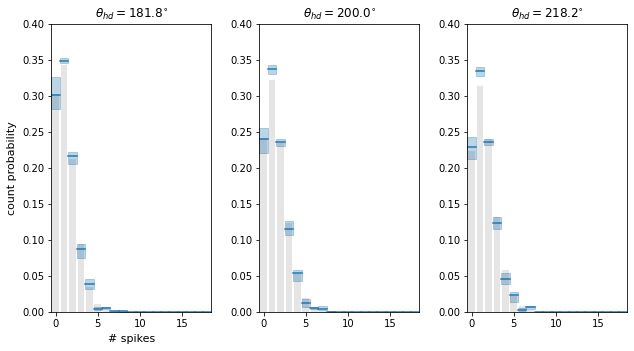

In [23]:
ne = 30  # select neuron to plot


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    
    # true count distribution
    bins = np.arange(max_count+1)
    gt_P = utils.stats.nb_count_prob(
        bins, rate[ne, step_ind], 1/r[ne, step_ind], tbin)
    
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    for k in range(max_count+1):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2) * median.numpy()[ne, step_ind, k]
        YY_l = np.ones(2) * lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2) * upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)
        
        ax.bar(XX_[0]+0.5, gt_P[k], color='k', alpha=0.1)


    ax.set_xlim([-0.5, max_count+.5])
    ax.set_ylim(0.0, 0.4)
    ax.set_xticks(np.arange(max_count+1)[::5])
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)

plt.show()

<a id='marg_single'></a>
### 3.2 Joint pair SCDs